In [1]:
import cv2
import sys
sys.path.append("..")
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from segment_anything import sam_model_registry, SamPredictor

In [2]:
sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = "cuda:1"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [3]:
def show_mask(mask, image, random_color=False):
    if random_color:
        color = np.random.choice(range(256), size=3)
    else:
        color = np.array([30, 144, 255])
    # mask = cv2.resize(mask,(image.shape[1],image.shape[0])) # 需要根據實際mask的大小和image大小進行調整
    mask = np.repeat(mask[:,:,np.newaxis],3,axis=2)
    mask = mask[:,:,:,0]
    image[mask[:,:,0]!=0] = color

def show_box(box, image):
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[2]), int(box[3]))
    color = (0, 255, 0)
    thickness = 2
    image = cv2.rectangle(image, start_point, end_point, color, thickness)

def get_mask(boxes,image):
    predictor.set_image(image)
    input_boxes = torch.tensor(boxes, device=predictor.device)
    
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    for mask in masks:
        mask = np.moveaxis(mask.cpu().numpy(),0,-1) # 把channel從第一個維度移動到最後一個維度
        show_mask(mask, image, random_color=True)
    for box in input_boxes:
        show_box(box.cpu().numpy(), image)
    return masks.cpu(), image

In [6]:
ROOT = '/home/mefae1/下載/GG/'
json_file = ROOT + 'annotations/instances_default.json'
labels = json.load(open(json_file, 'r', encoding='utf-8'))

  0%|          | 0/7 [00:00<?, ?it/s]

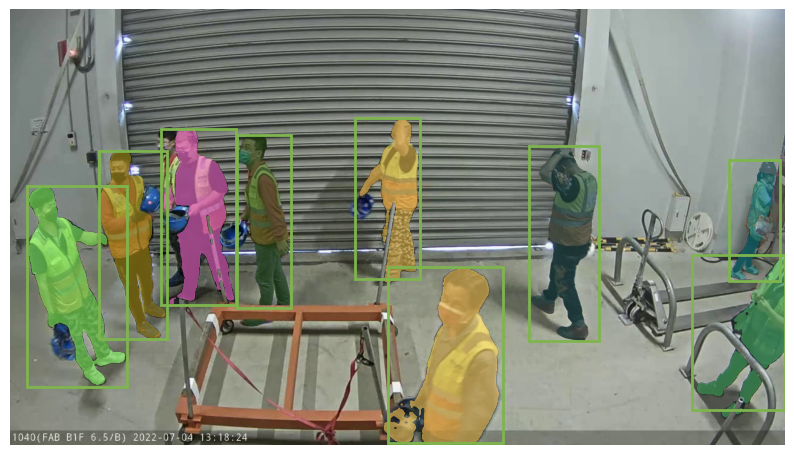

 14%|█▍        | 1/7 [00:01<00:10,  1.73s/it]

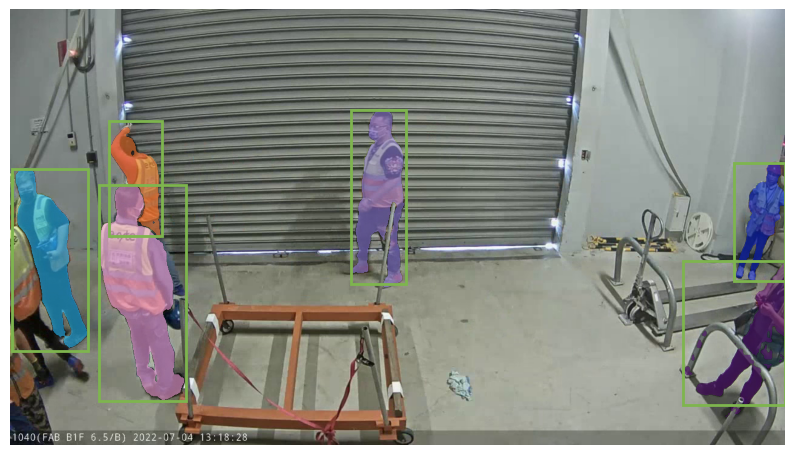

 29%|██▊       | 2/7 [00:02<00:06,  1.34s/it]

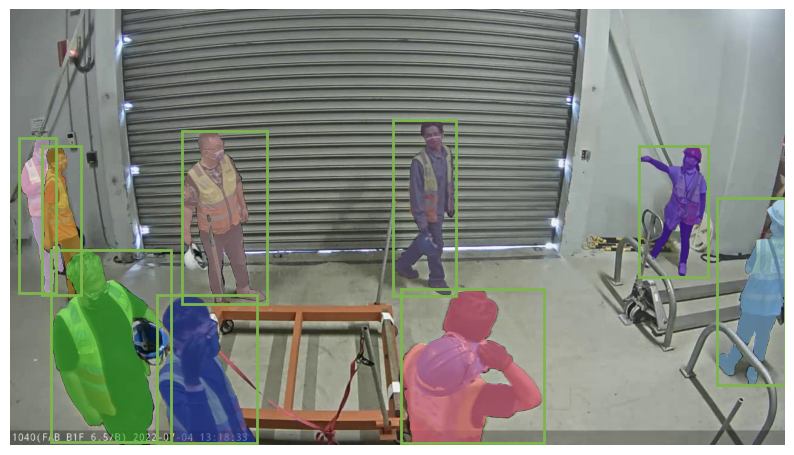

 43%|████▎     | 3/7 [00:04<00:05,  1.29s/it]

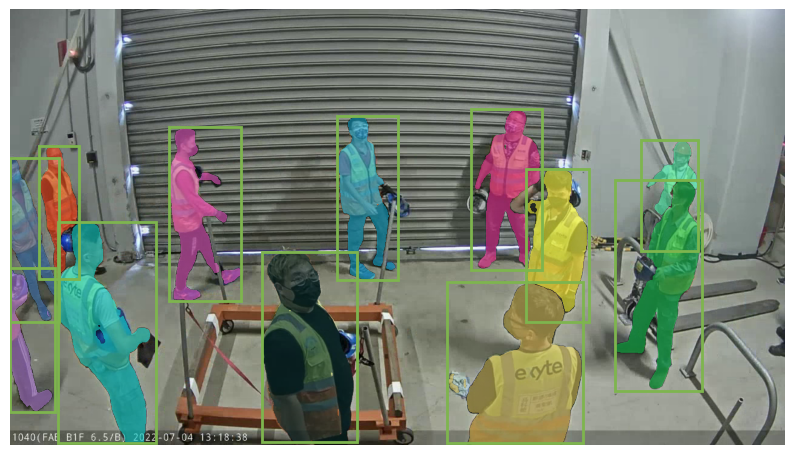

 57%|█████▋    | 4/7 [00:05<00:04,  1.35s/it]

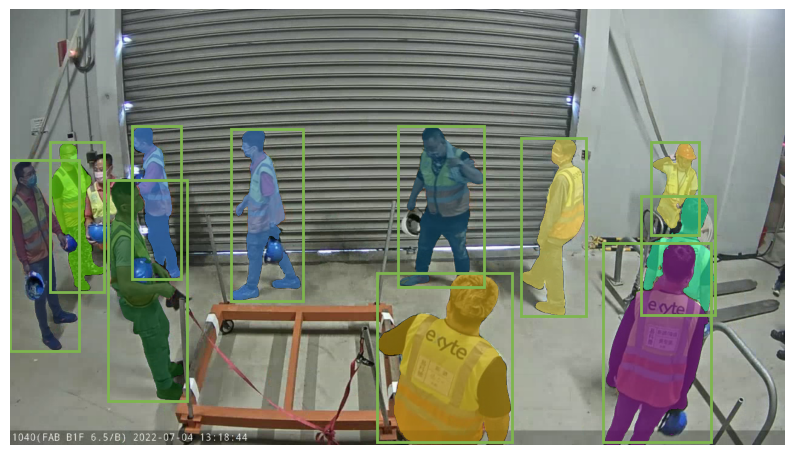

 71%|███████▏  | 5/7 [00:06<00:02,  1.36s/it]

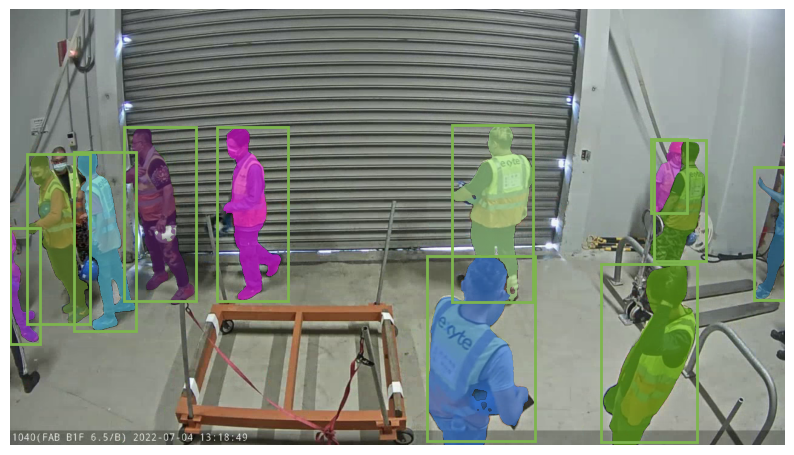

 86%|████████▌ | 6/7 [00:08<00:01,  1.37s/it]

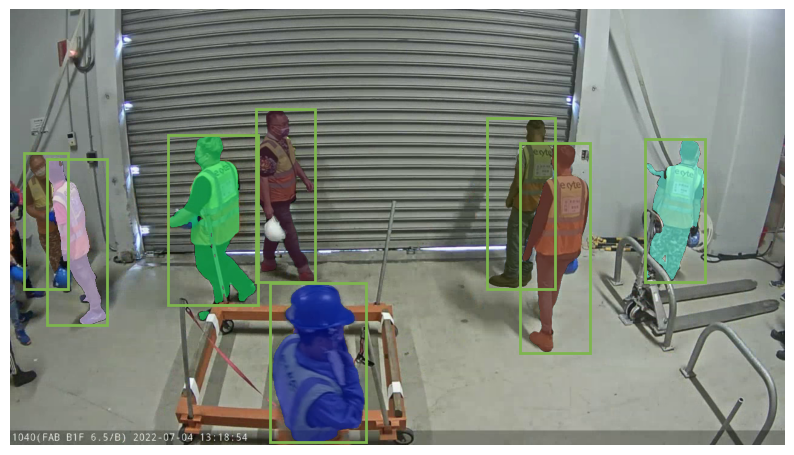

100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


In [7]:
image_len = len(labels['images'])
l = 0

for index in tqdm(range(image_len)):
    image_path = labels['images'][index]['file_name']
    image = cv2.imread(ROOT + 'images/' + image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = []  # to store the boxes
    
    for annotation in labels['annotations']:
        if annotation['image_id'] == index + 1:
            x, y, w, h = annotation['bbox']
            x1,y1,x2,y2 = x,y,int(x+w),int(y+h)
            boxes.append([x1,y1,x2,y2])
            
    if len(boxes) > 0:
        masks,image = get_mask(boxes,image)
    
        for i, (mask,label) in enumerate(zip(masks,labels['annotations'])):
        
            binary_mask = masks[i].squeeze().numpy().astype(np.uint8)
        
            # Find the contours of the mask
            contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
            largest_contour = max(contours, key=cv2.contourArea)
        
            # Get the new bounding box
            bbox = [int(x) for x in cv2.boundingRect(largest_contour)]
        
            # Get the segmentation mask for object 
            segmentation = largest_contour.flatten().tolist()
            labels['annotations'][l]['segmentation'] = [segmentation]
            l += 1

In [8]:
# Serializing json
json_object = json.dumps(labels, indent=4)
 
# Writing to sample.json
with open("instances_default.json", "w") as outfile:
    outfile.write(json_object)

In [9]:
labels['annotations'][i]['segmentation']

[[748,
  427,
  747,
  428,
  743,
  428,
  742,
  429,
  739,
  429,
  738,
  430,
  736,
  430,
  735,
  431,
  734,
  431,
  733,
  432,
  731,
  432,
  730,
  433,
  729,
  433,
  728,
  434,
  727,
  434,
  723,
  438,
  722,
  438,
  717,
  443,
  717,
  444,
  716,
  445,
  716,
  450,
  715,
  451,
  715,
  455,
  716,
  456,
  716,
  457,
  715,
  458,
  715,
  465,
  714,
  466,
  714,
  470,
  713,
  471,
  713,
  473,
  712,
  474,
  712,
  476,
  711,
  477,
  711,
  482,
  709,
  484,
  709,
  485,
  708,
  486,
  708,
  489,
  707,
  490,
  707,
  498,
  708,
  499,
  708,
  504,
  709,
  505,
  709,
  507,
  710,
  508,
  710,
  509,
  711,
  510,
  711,
  511,
  713,
  513,
  713,
  514,
  714,
  515,
  714,
  516,
  715,
  517,
  715,
  521,
  709,
  527,
  709,
  528,
  708,
  529,
  708,
  530,
  706,
  532,
  706,
  533,
  705,
  534,
  705,
  536,
  704,
  537,
  704,
  538,
  703,
  539,
  703,
  540,
  702,
  541,
  702,
  543,
  701,
  544,
  701,
  550,
  700,